# Tutorial 6: Setup -- Policies

As show in previous tutorials, the settings file can be changed to adapt to a number of different systems. In Tutorial 3, we discussed how the setting Time Domain Reduction can reduce the computation time of the solver. Other settings, however, directly impact the values of the solution itself. This tutorial goes over the policy attributes in the settings and shows how implementing certain policies affects the optimal solution in GenX. To demonstrate these effects, we will be using `SmallNewEngland/ThreeZones`.

As a reminder, the setup of the model is the specified settings from your `genx_settings.yml` combined with the default settings for those not specified in the YAML file.

In [1]:
using JuMP
using HiGHS
using GenX

In [3]:
case = joinpath("Example_Systems_Tutorials/SmallNewEngland/ThreeZones") 

genx_settings = GenX.get_settings_path(case, "genx_settings.yml");
setup = GenX.configure_settings(genx_settings)


Configuring Settings


Dict{Any, Any} with 24 entries:
  "NetworkExpansion"                        => 1
  "TimeDomainReductionFolder"               => "TDR_Results"
  "EnableJuMPStringNames"                   => false
  "Trans_Loss_Segments"                     => 1
  "ModelingtoGenerateAlternativeSlack"      => 0.1
  "Solver"                                  => "HiGHS"
  "Reserves"                                => 0
  "MultiStage"                              => 0
  "OverwriteResults"                        => 0
  "ModelingToGenerateAlternatives"          => 0
  "MaxCapReq"                               => 0
  "MinCapReq"                               => 1
  "CO2Cap"                                  => 2
  "WriteShadowPrices"                       => 1
  "ModelingToGenerateAlternativeIterations" => 3
  "ParameterScale"                          => 1
  "EnergyShareRequirement"                  => 0
  "PrintModel"                              => 0
  "TimeDomainReduction"                     => 1
  "CapacityRe

The settings we'll focus on here are `MaxCapReq`, `MinCapReq`, `CO2Cap`, `EnergyShareRequirement`, and `CapacityReserveMargin`. Each of these ensures that the environmental impact of the model is taken into account, and are therefore referred to as __policy settings__ https://genxproject.github.io/GenX/dev/policies/. For more information on what each one does, see the documentation.

In [8]:
println("MaxCapReq: ", setup["MaxCapReq"])
println("MinCapReq: ", setup["MinCapReq"])
println("CO2Cap: ", setup["CO2Cap"])
println("EnergyShareRequirement: ", setup["EnergyShareRequirement"])
println("CapacityReserveMargin: ", setup["CapacityReserveMargin"])

MaxCapReq: 0
MinCapReq: 1
CO2Cap: 2
EnergyShareRequirement: 0
CapacityReserveMargin: 0


`SmallNewEngland/ThreeZones` uses `MinCapReq` and `CO2Cap`. For the purpose of this tutorial, we're going to set these back to zero to start.

In [9]:
setup["MinCapReq"] = 0
setup["CO2Cap"] = 0

0

In [10]:
setup

Dict{Any, Any} with 24 entries:
  "NetworkExpansion"                        => 1
  "TimeDomainReductionFolder"               => "TDR_Results"
  "EnableJuMPStringNames"                   => false
  "Trans_Loss_Segments"                     => 1
  "ModelingtoGenerateAlternativeSlack"      => 0.1
  "Solver"                                  => "HiGHS"
  "Reserves"                                => 0
  "MultiStage"                              => 0
  "OverwriteResults"                        => 0
  "ModelingToGenerateAlternatives"          => 0
  "MaxCapReq"                               => 0
  "MinCapReq"                               => 0
  "CO2Cap"                                  => 0
  "WriteShadowPrices"                       => 1
  "ModelingToGenerateAlternativeIterations" => 3
  "ParameterScale"                          => 1
  "EnergyShareRequirement"                  => 0
  "PrintModel"                              => 0
  "TimeDomainReduction"                     => 1
  "CapacityRe

Now, we'll generate and solve the model using these results:

In [11]:
settings_path = GenX.get_settings_path(case)

### Create TDR_Results
TDRpath = joinpath(case, setup["TimeDomainReductionFolder"])

if setup["TimeDomainReduction"] == 1
    GenX.prevent_doubled_timedomainreduction(case)
    if !GenX.time_domain_reduced_files_exist(TDRpath)
        println("Clustering Time Series Data (Grouped)...")
        GenX.cluster_inputs(case, settings_path, setup)
    else
        println("Time Series Data Already Clustered.")
    end
end

OPTIMIZER =  GenX.configure_solver(setup["Solver"], settings_path);

inputs = GenX.load_inputs(setup, case)

Time Series Data Already Clustered.
Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
CSV Files Successfully Read In From Example_Systems_Tutorials/SmallNewEngland/ThreeZones


Dict{Any, Any} with 58 entries:
  "Z"                       => 3
  "LOSS_LINES"              => [1, 2]
  "RET_CAP_CHARGE"          => Int64[]
  "pC_D_Curtail"            => [50.0, 45.0, 27.5, 10.0]
  "dfGen"                   => 10×65 DataFrame…
  "pTrans_Max_Possible"     => [5.9, 4.0]
  "pNet_Map"                => [1.0 -1.0 0.0; 1.0 0.0 -1.0]
  "omega"                   => [4.01099, 4.01099, 4.01099, 4.01099, 4.01099, 4.…
  "pMax_Line_Reinforcement" => [2.95, 2.0]
  "RET_CAP_ENERGY"          => [8, 9, 10]
  "RESOURCES"               => String31["MA_natural_gas_combined_cycle", "MA_so…
  "COMMIT"                  => [1, 3, 6]
  "pMax_D_Curtail"          => [1.0, 0.04, 0.024, 0.003]
  "STOR_ALL"                => [8, 9, 10]
  "THERM_ALL"               => [1, 3, 6]
  "REP_PERIOD"              => 11
  "STOR_LONG_DURATION"      => Int64[]
  "STOR_SYMMETRIC"          => [8, 9, 10]
  "VRE"                     => [2, 4, 5, 7]
  "RETRO"                   => Int64[]
  "THERM_COMMIT"          

In [12]:
EP = GenX.generate_model(setup,inputs,OPTIMIZER)

Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Emissions Module (for CO2 Policy modularization
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module


A JuMP Model
Minimization problem with:
Variables: 83189
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 24024 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 103506 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 79492 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS
Names registered in the model: cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCNSE, eCStart, eCVar_in, eCVar_out, eELOSS, eELOSSByZone, eEmissionsByPlant, eEmissionsByZone, eExistingCap, eExisting

In [13]:
GenX.solve_model(EP,setup)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
123651 rows, 81156 cols, 433779 nonzeros
116285 rows, 73790 cols, 435111 nonzeros
Presolve : Reductions: rows 116285(-31576); columns 73790(-9399); elements 435111(-74634)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 5544(8983.39); Du: 0(4.19819e-09) 0s
      14650     2.2391992950e+03 Pr: 37215(1.0183e+06); Du: 0(0.000474248) 5s
      21061     2.7392588523e+03 Pr: 40709(1.13739e+06); Du: 0(0.000991412) 10s
      32702     3.5040189262e+03 Pr: 30581(174811); Du: 0(0.0023772) 15s
      42440     3.8000545141e+03 Pr: 21167(412755); Du: 0(0.00264733) 20s
      50905     3.9956815641e+03 Pr: 27406(126085); Du: 0(0.00242539) 26s
      58906     4.1978941982e+03 Pr: 34647(1.00472e+06); Du: 0(0.00277306) 31s
      66918     4.3089269386e+03 Pr: 20848(72230.9); Du: 0(0.00287916) 36s
      75483 

(A JuMP Model
Minimization problem with:
Variables: 83189
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 24024 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 103506 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 79492 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCNSE, eCStart, eCVar_in, eCVar_out, eELOSS, eELOSSByZone, eEmissionsByPlant, eEmissionsByZone, eExistingCap, eExis

Using `value.()`, we can see what the total capacity is of the optimized model:

In [21]:
totCap_base = value.(EP[:eTotalCap])

10-element Vector{Float64}:
 13.584204908462493
  0.0
  9.79630221915
  0.0
  0.0
  0.278738260603956
  0.0
  0.0
  0.0
  0.0

In [22]:
using Plots

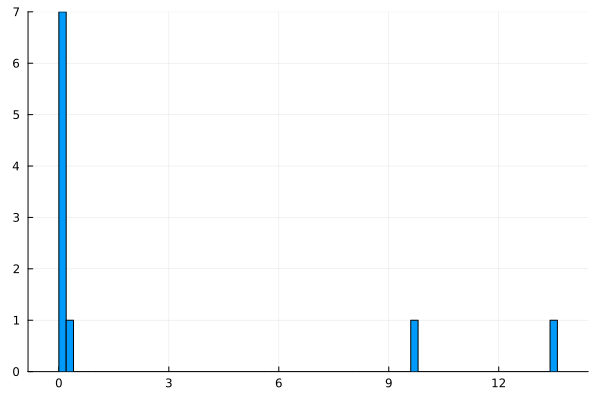

In [46]:
histogram(totCap_base,label=false)

In [24]:
setup["MinCapReq"] = 1
setup["CO2Cap"] = 2

2

In [28]:
RT = inputs["dfGen"][:,:Resource_Type]

10-element Vector{String}:
 "natural_gas_fired_combined_cycle"
 "solar_photovoltaic"
 "natural_gas_fired_combined_cycle"
 "onshore_wind_turbine"
 "solar_photovoltaic"
 "natural_gas_fired_combined_cycle"
 "onshore_wind_turbine"
 "battery_mid"
 "battery_mid"
 "battery_mid"

In [27]:
## Delte TDR Results
if "TDR_Results" in cd(readdir,"Example_Systems_Tutorials/SmallNewEngland/ThreeZones")
    rm("Example_Systems_Tutorials/SmallNewEngland/ThreeZones/TDR_results", recursive=true) 
end

## Create new TDR Results
GenX.prevent_doubled_timedomainreduction(case)
GenX.cluster_inputs(case, settings_path, setup)

inputs = GenX.load_inputs(setup, case)
EP2 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP2,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
Minimum_capacity_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From Example_Systems_Tutorials/SmallNewEngland/ThreeZones
Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
Minimum_capacity_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From Example_Systems_Tutorials/SmallNewEngland/ThreeZones
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Emissions Module (for CO2 Policy modularization
Transmission Module
Dispatchable Resources Module
Storage

(A JuMP Model
Minimization problem with:
Variables: 83192
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 24024 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20334 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 103509 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 79492 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: cCO2Emissions_systemwide, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cTAuxLimit, cTAuxSum, cTLoss, cZoneMinCapReq, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCNSE, eCStart, eCVar_in, eCVar_out, eELOSS, eELOSSByZone, eEmissionsByP

In [35]:
totCap2 = value.(EP2[:eTotalCap])

10-element Vector{Float64}:
  8.419104230814321
 16.90722089526039
  2.1653067772851156
 14.441954343031803
 15.953402453465536
  0.5731491932740814
 10.683948973110489
  2.1946099131499994
  5.114380761247893
  2.182888951004729

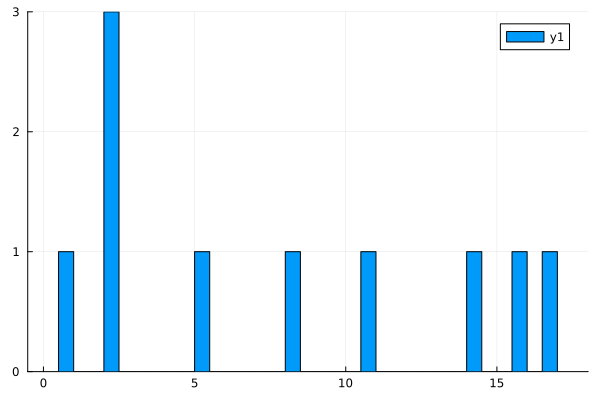

In [50]:
histogram(totCap2,bins=50)

In [ ]:
## Delte TDR Results
if "TDR_Results" in cd(readdir,"Example_Systems_Tutorials/SmallNewEngland/ThreeZones")
    rm("Example_Systems_Tutorials/SmallNewEngland/ThreeZones/TDR_results", recursive=true) 
end

## Create new TDR Results
GenX.prevent_doubled_timedomainreduction(case)
GenX.cluster_inputs(case, settings_path, setup)

inputs = GenX.load_inputs(setup, case)
EP2 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP2,setup)